#### Grad-CAM fine-tuning a pre-trained model for cats and dogs classification problem

Lets grab the pre-trained MobileNetV2 model

Rescaling layer, MobileNetV2 layers, global average pooling layer, dropout layer with 10% dropout, and a dense prediction layer.
MobileNetV2 layer weights were not adjusted during training.
Trained on a subset of 1,600 images of cats & dogs.
Dynamically adjusted our learning rate during training using a polynomial decay schedule with an initial learning rate of 1e-3

In [14]:
!gdown --id 16TddcHu8Zdznp-Xg8ckNz53wm70q6Xh0

C:\Users\DDoS\AppData\Local\Programs\Python\Python310\lib\site-packages\gdown\cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16TddcHu8Zdznp-Xg8ckNz53wm70q6Xh0
To: c:\Users\DDoS\Jupyter\Grad-CAM\mobilenetv2_epochs25_batch25_sample_size2000_aug_0.h5

  0%|          | 0.00/9.52M [00:00<?, ?B/s]
  6%|▌         | 524k/9.52M [00:00<00:09, 913kB/s]
 11%|█         | 1.05M/9.52M [00:01<00:08, 958kB/s]
 17%|█▋        | 1.57M/9.52M [00:01<00:08, 966kB/s]
 22%|██▏       | 2.10M/9.52M [00:02<00:07, 983kB/s]
 28%|██▊       | 2.62M/9.52M [00:02<00:06, 987kB/s]
 33%|███▎      | 3.15M/9.52M [00:03<00:06, 995kB/s]
 39%|███▊      | 3.67M/9.52M [00:03<00:05, 1.00MB/s]
 44%|████▍     | 4.19M/9.52M [00:04<00:05, 998kB/s] 
 50%|████▉     | 4.72M/9.52M [00:04<00:05, 933kB/s]
 55%|█████▌    | 5.24M/9.52M [00:05<00:04, 955kB/s]
 61%|██████

In [30]:
!gdown --id 1-3360B0mciNsg-tLaj482APOR9IPYVUT

from zipfile import ZipFile

with ZipFile(r"C:\Users\DDoS\Jupyter\Grad-CAM\val_1000.zip", 'r') as zipobj:
   # Extract all the contents of zip file in current directory
   zipobj.extractall()

In [6]:
import random
from random import shuffle 
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.utils.data_utils import Sequence

In [9]:
def label_image_one_hot_encoder(img):
  ## Helper for process_data
  label = img.split('_')[0]
  if label == 'cat': return 0
  elif label == 'dog': return 1


def process_data(image_list, DATA_FOLDER, IMG_SIZE):
  ## Helper for manual_pre_process
  ## Creates an array of images, labels, and file path
  ## Shuffles the array before returning
  data_df = []
  for img in tqdm(image_list):
    path = os.path.join(DATA_FOLDER, img)
    label = label_image_one_hot_encoder(img)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    data_df.append([np.array(img), np.array(label), path])
  shuffle(data_df)
  return data_df


def manual_pre_process(dir, IMG_SIZE):
  '''
  Creates an array of images, labels, and files from a directory of image files
  
  Args:
    dir: string, folder name
    IMG_SIZE: int, image height and width

  Returns 
    X: (n x IMG_SIZE x IMG_SIZE) numpy array of images
    y: (n,) numpy array of labels
    files: (n,) numpy array of files

  '''
  image_lst = os.listdir(dir)
  data_df = process_data(image_lst, dir, IMG_SIZE)
  X = np.array([i[0] for i in data_df]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  y = np.array([i[1] for i in data_df])
  files = np.array([i[2] for i in data_df])
  return X, y, files

In [ ]:
val_imgs = 'val_1000'
class_info = {0: 'Cat', 1: 'Dog'}

X, y, files = manual_pre_process(val_imgs, 224)

100%|██████████| 1000/1000 [00:05<00:00, 187.85it/s]


#### Loading the Pre-Trained Model

In [32]:
import tensorflow as tf
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [33]:
model = tf.keras.models.load_model('mobilenetv2_epochs25_batch25_sample_size2000_aug_0.h5', custom_objects={"precision_m": precision, "recall_m": recall})

#### Results with Grad-CAM

In [34]:
def decode_prediction(pred):
  # This function thresholds a probability to produce a prediction
  pred = tf.where(pred < 0.5, 0, 1)
  return pred.numpy()

In [48]:
# import numpy as np
# pred = np.array([0.3, 0.7, 3, 4, 5, 6, 7])
# pred = tf.where(pred < 0.5, 0, 1)
# pred

<tf.Tensor: shape=(7,), dtype=int32, numpy=array([0, 1, 1, 1, 1, 1, 1])>

[[0.99891454]]


Text(0.5, 1.0, 'Dog 0.99891454')

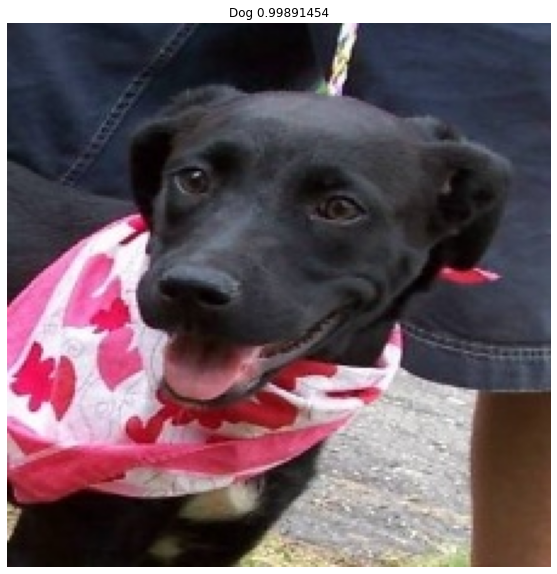

In [54]:
img = X[59]
label = y[59]
path = files[59]

pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]

pred = decode_prediction(pred_raw)
pred_label = class_info[pred]

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(pred_label + ' ' + str(pred_raw))

In [56]:
from tensorflow.keras.models import Model



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

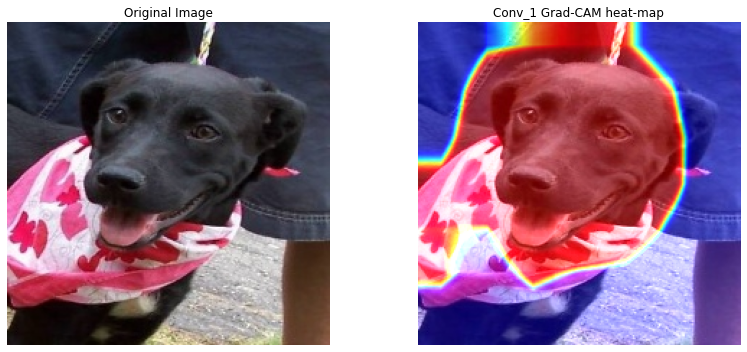

In [59]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1

layer_name = 'Conv_1'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()

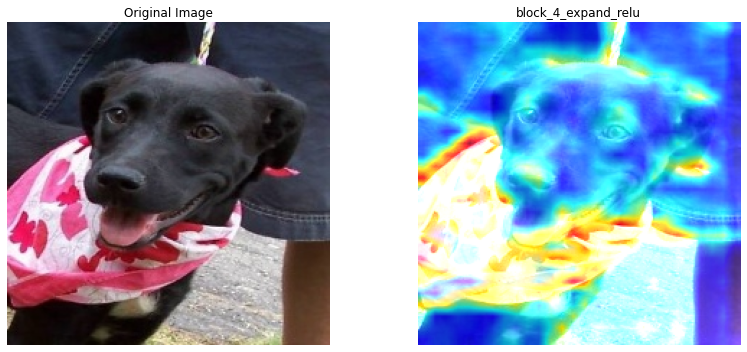

In [60]:
## Grad-CAM heatmap for the block_4_expand_relu
## This layer shows how the model begins learning concepts in the image

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
grad_cam = GradCam(model, np.expand_dims(img, axis=0), 'block_4_expand_relu')
grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
plt.imshow(grad_cam_emphasized)
plt.axis('off')
plt.title('block_4_expand_relu')
plt.tight_layout()


In [61]:
## Gather all convolution and activation layers from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model

conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D))]


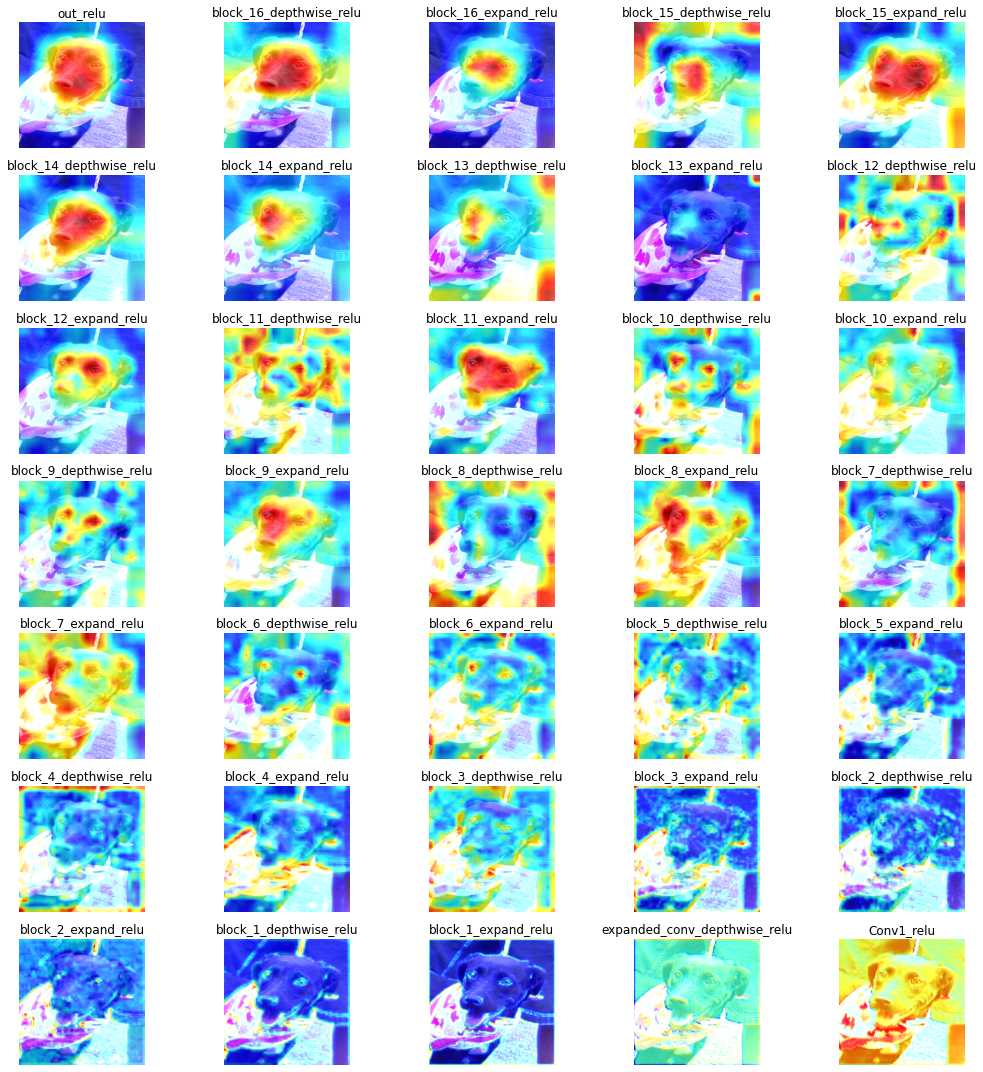

In [62]:
## Visualizing Activation layers
plt.figure(figsize=(15, 15))
for i, layer in enumerate(activation_layers):
  grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
  grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
  ax = plt.subplot(7, 5, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()


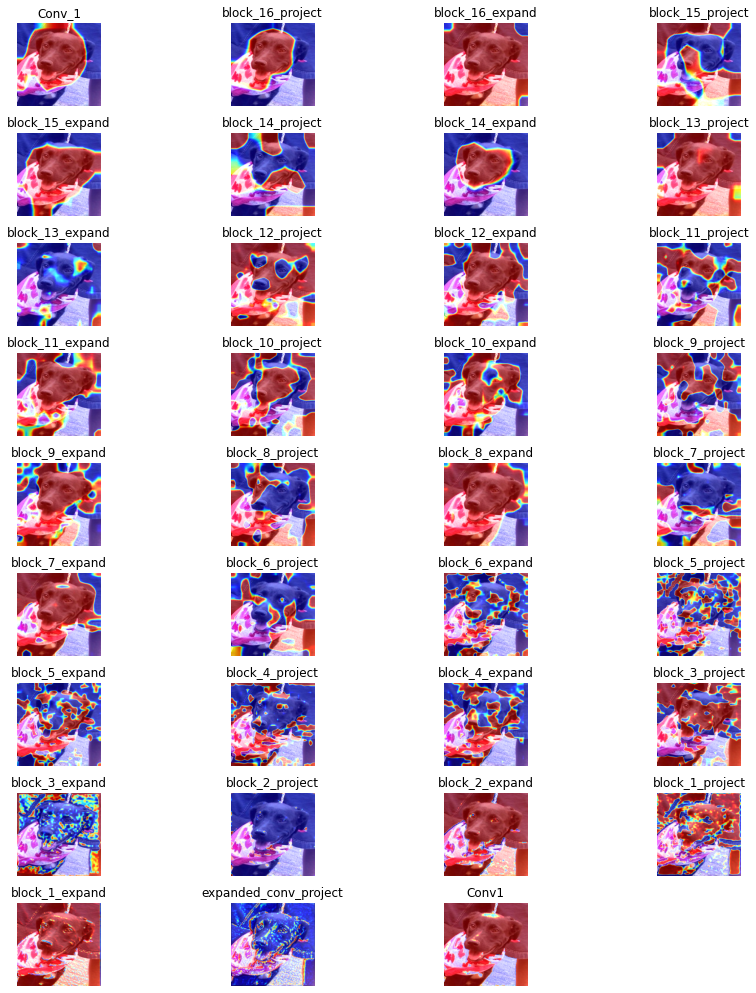

In [63]:
## Visualizing Convolution layers
plt.figure(figsize=(12, 20))
for i, layer in enumerate(conv2D_layers):
  grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
  grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=True)
  ax = plt.subplot(13, 4, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()


In [64]:
def fuse_layers(layers, model, img, emphasize=False):
  '''
    Fuses grad-cam heatmaps from a list of model layers into a single heatmap
    and superimposes the heatmap onto an image.

    Args:
      layers: list of strings
      model: tf model
      img: (img_width x img_height x 3) numpy array


    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
  cams = []
  for layer in layers:
    cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cams.append(cam)

  fused = np.mean(cams, axis=0)
  superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)

  return superimposed


In [65]:
## Using the fuse_layers function, lets fuse together all layers in the model

fused = fuse_layers(all_layers, model, img, True)

Text(0.5, 1.0, 'All layers Grad-CAM heat-map')

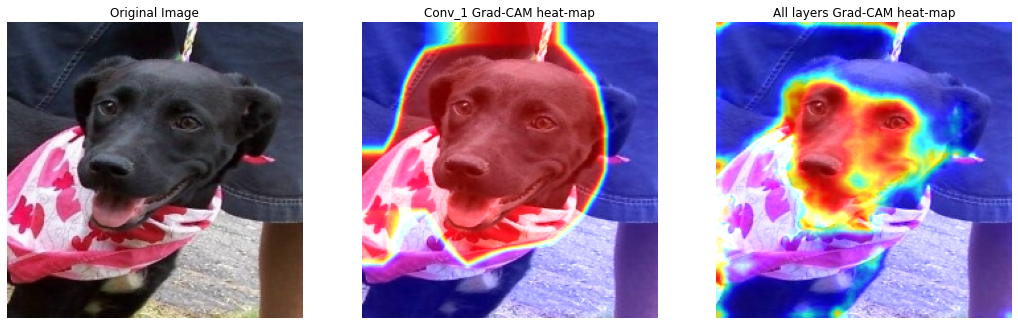

In [66]:
## We can see how fusing together all layers improves upon the Grad-CAM from the last
## convolutional layer in the model

plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')


In [67]:
## Looking at Grad-CAM for 3 random images in the dataset

imgs = [X[54], X[26], X[136]]
labels = [y[54], y[26], y[136]]
paths = [files[54], files[26], files[136]]

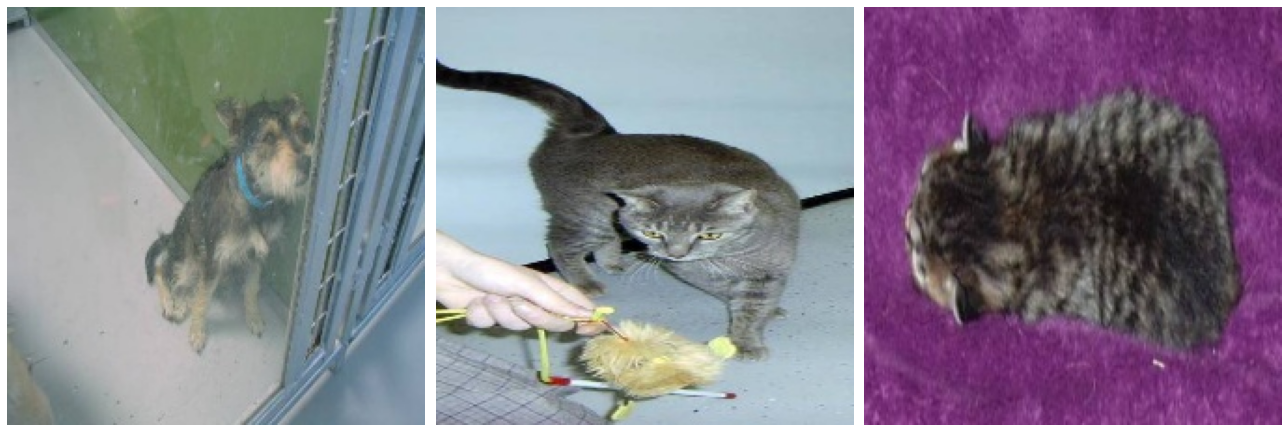

In [68]:
plt.figure(figsize=(18, 8))
for i, (img, label) in enumerate(zip(imgs, labels)):
  ax = plt.subplot(1, 3, i+1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
plt.tight_layout()


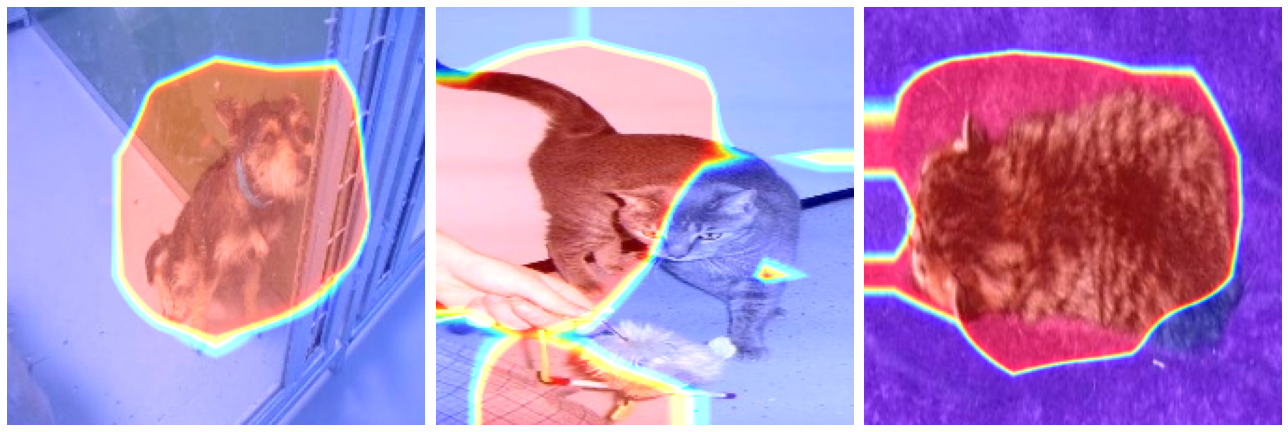

In [69]:
plt.figure(figsize=(18, 8))
for i, (img, label) in enumerate(zip(imgs, labels)):
  ax = plt.subplot(1, 3, i+1)
  grad_cam=GradCam(model,np.expand_dims(img, axis=0),'Conv_1')
  grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)
  plt.imshow(grad_cam_superimposed)
  plt.axis('off')
plt.tight_layout()

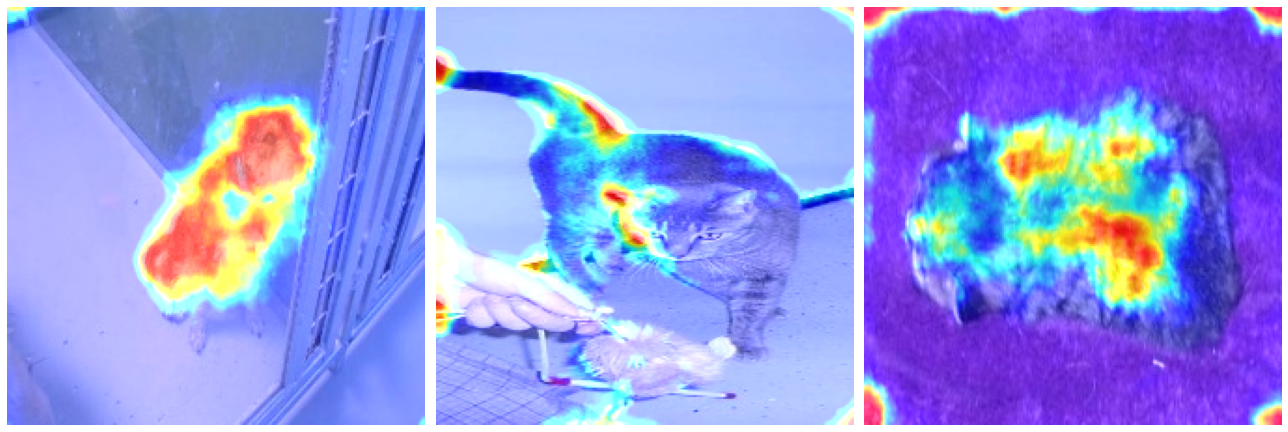

In [70]:
plt.figure(figsize=(18, 8))
for i, (img, label) in enumerate(zip(imgs, labels)):
  ax = plt.subplot(1, 3, i+1)
  fused = fuse_layers(all_layers, model, img, True)
  plt.imshow(fused)
  plt.axis('off')
plt.tight_layout()